In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


le nuage de point est affiché sur tous le dataset RSNA pour voir comment le modele final s'ajuste aux
 données


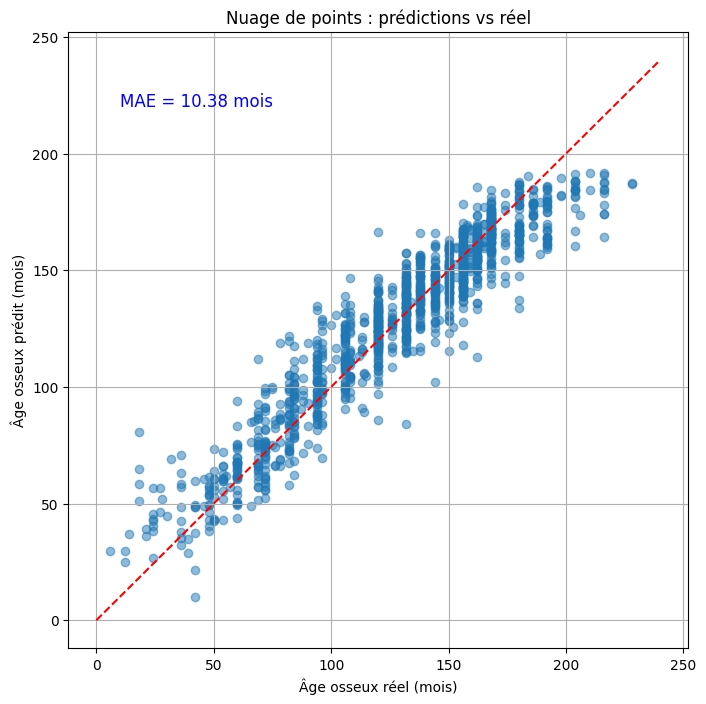

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

# === Chemins ===
BASE_DIR = "/content/drive/MyDrive"
csv_path = os.path.join(BASE_DIR, "bone_age_project/data/labels.csv")
images_folder = os.path.join(BASE_DIR, "bone_age_project/data/images")
model_path = os.path.join(BASE_DIR, "bone_age_project/best_model_final9.h5")

# === Rechargement des données ===
df = pd.read_csv(csv_path)

# === Refaire le split avec le même random_state ===
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# === Fonctions de preprocessing (reprendre ce que tu as défini) ===
def normalize_intensity(image):
    image = tf.cast(image, tf.float32) / 255.0
    mean = tf.reduce_mean(image)
    std = tf.math.reduce_std(image)
    return (image - mean) / (std + 1e-5)

def resize_with_pad(image, target_height=224, target_width=224):
    return tf.image.resize_with_pad(image, target_height, target_width)

def preprocess_image(image_path):
    image_str = tf.io.read_file(image_path)
    image = tf.image.decode_png(image_str, channels=1)
    image = normalize_intensity(image)
    image = resize_with_pad(image)
    return image

def create_dataset(dataframe, batch_size=32):
    image_paths = [os.path.join(images_folder, str(id) + ".png") for id in dataframe['id']]
    ages = dataframe['boneage'].values / 228.0
    genders = dataframe['male'].astype(np.float32).values

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, (ages, genders)))

    dataset = dataset.map(
        lambda path, y: (
            {'image_input': preprocess_image(path), 'gender_input': tf.cast(y[1], tf.float32)},
            tf.cast(y[0], tf.float32)
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# === Création du dataset test ===
test_dataset = create_dataset(test_df, batch_size=32)

# === Chargement du modèle ===
model = load_model(model_path, custom_objects={'mse': tf.keras.metrics.MeanSquaredError()})
assert isinstance(model.input, list), "Le modèle ne semble pas avoir deux entrées (image + genre)"

# === Prédictions ===
y_true = []
y_pred = []

for batch in test_dataset:
    inputs, targets = batch
    preds = model.predict(inputs, verbose=0)
    y_true.extend(targets.numpy())
    y_pred.extend(preds.flatten())

# === Rétablir l'échelle d'âge en mois ===
y_true = np.array(y_true) * 228
y_pred = np.array(y_pred) * 228

# === Affichage du nuage de points ===
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 240], [0, 240], 'r--')
plt.xlabel("Âge osseux réel (mois)")
plt.ylabel("Âge osseux prédit (mois)")
plt.title("Nuage de points : prédictions vs réel")
plt.grid(True)

# Calcul MAE
mae = np.mean(np.abs(y_true - y_pred))
plt.text(10, 220, f"MAE = {mae:.2f} mois", fontsize=12, color='blue')
plt.show()
